In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from scipy.stats import skew

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'

In [246]:
train = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
train

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [247]:
d_map = {}
for i, d in enumerate(train['구분'].unique()):
    d_map[d] = i
train['구분'] = train['구분'].map(d_map)
train

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [248]:
train['연월일'] = pd.to_datetime(train['연월일'])
train

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [249]:
train['year'] = train['연월일'].dt.year
train['month'] = train['연월일'].dt.month
train['day'] = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday
train['weekofyear'] = train['연월일'].dt.weekofyear
train['dayofyear'] = train['연월일'].dt.dayofyear
train.rename(columns={'시간':'hour', '구분':'type'}, inplace=True)
train

,연월일,hour,type,공급량,year,month,day,weekday,weekofyear,dayofyear
0,2013-01-01,1,0,2497.129,2013,1,1,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0,1,365
368084,2018-12-31,21,6,669.961,2018,12,31,0,1,365
368085,2018-12-31,22,6,657.941,2018,12,31,0,1,365
368086,2018-12-31,23,6,610.953,2018,12,31,0,1,365


In [250]:
train = train[['type', 'month', 'day', 'hour', 'weekday', 'weekofyear', 'dayofyear', '공급량']]
train

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,2497.129
1,0,1,1,2,1,1,1,2363.265
2,0,1,1,3,1,1,1,2258.505
3,0,1,1,4,1,1,1,2243.969
4,0,1,1,5,1,1,1,2344.105
...,...,...,...,...,...,...,...,...
368083,6,12,31,20,0,1,365,681.033
368084,6,12,31,21,0,1,365,669.961
368085,6,12,31,22,0,1,365,657.941
368086,6,12,31,23,0,1,365,610.953


In [251]:
test = pd.read_csv('data/test.csv')
test

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A
...,...
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H


In [252]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['type'] = test['일자|시간|구분'].str.split(' ').str[2]
test

,일자|시간|구분,일자,hour,type
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [253]:
test['type'] = test['type'].map(d_map)
test

,일자|시간|구분,일자,hour,type
0,2019-01-01 01 A,2019-01-01,1,0
1,2019-01-01 02 A,2019-01-01,2,0
2,2019-01-01 03 A,2019-01-01,3,0
3,2019-01-01 04 A,2019-01-01,4,0
4,2019-01-01 05 A,2019-01-01,5,0
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,6
15116,2019-03-31 21 H,2019-03-31,21,6
15117,2019-03-31 22 H,2019-03-31,22,6
15118,2019-03-31 23 H,2019-03-31,23,6


In [254]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday
test['weekofyear'] = test['일자'].dt.weekofyear
test['dayofyear'] = test['일자'].dt.dayofyear
test

,일자|시간|구분,일자,hour,type,year,month,day,weekday,weekofyear,dayofyear
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,1,1
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,1,1
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,1,1
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,1,1
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,13,90
15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,13,90
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,13,90
15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,13,90


In [255]:
test = test[['type', 'month', 'day', 'hour', 'weekday', 'weekofyear', 'dayofyear']]
test

,type,month,day,hour,weekday,weekofyear,dayofyear
0,0,1,1,1,1,1,1
1,0,1,1,2,1,1,1
2,0,1,1,3,1,1,1
3,0,1,1,4,1,1,1
4,0,1,1,5,1,1,1
...,...,...,...,...,...,...,...
15115,6,3,31,20,6,13,90
15116,6,3,31,21,6,13,90
15117,6,3,31,22,6,13,90
15118,6,3,31,23,6,13,90


In [256]:
train

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,2497.129
1,0,1,1,2,1,1,1,2363.265
2,0,1,1,3,1,1,1,2258.505
3,0,1,1,4,1,1,1,2243.969
4,0,1,1,5,1,1,1,2344.105
...,...,...,...,...,...,...,...,...
368083,6,12,31,20,0,1,365,681.033
368084,6,12,31,21,0,1,365,669.961
368085,6,12,31,22,0,1,365,657.941
368086,6,12,31,23,0,1,365,610.953


In [257]:
df1 = train.append(test)
df1

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,2497.129
1,0,1,1,2,1,1,1,2363.265
2,0,1,1,3,1,1,1,2258.505
3,0,1,1,4,1,1,1,2243.969
4,0,1,1,5,1,1,1,2344.105
...,...,...,...,...,...,...,...,...
15115,6,3,31,20,6,13,90,NaN
15116,6,3,31,21,6,13,90,NaN
15117,6,3,31,22,6,13,90,NaN
15118,6,3,31,23,6,13,90,NaN


In [258]:
df = df1.sample(frac=1, random_state=100).reset_index(drop=True)
df

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,4,3,20,23,1,12,79,2515.207
1,2,1,21,1,0,4,21,NaN
2,5,3,28,3,1,13,87,1891.637
3,2,4,13,14,3,15,103,109.378
4,1,4,22,11,0,17,112,977.093
...,...,...,...,...,...,...,...,...
383203,3,10,9,8,1,41,282,514.665
383204,0,12,14,24,3,50,348,2662.203
383205,3,1,19,12,1,3,19,1628.997
383206,6,5,28,1,1,22,148,100.468


In [259]:
df['type'] = df['type'].map(df['공급량'].groupby(df['type']).mean())
df['month'] = df['month'].map(df['공급량'].groupby(df['month']).mean())
df['day'] = df['day'].map(df['공급량'].groupby(df['day']).mean())
df['hour'] = df['hour'].map(df['공급량'].groupby(df['hour']).mean())
df['weekday'] = df['weekday'].map(df['공급량'].groupby(df['weekday']).mean())
df['weekofyear'] = df['weekofyear'].map(df['공급량'].groupby(df['weekofyear']).mean())
df['dayofyear'] = df['dayofyear'].map(df['공급량'].groupby(df['dayofyear']).mean())

In [260]:
df

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,1395.356673,1209.032748,944.001457,1011.378763,983.333307,1120.250730,1118.775864,2515.207
1,131.585481,1833.304906,944.753501,821.285596,960.247853,1898.391316,1831.691913,NaN
2,2070.685900,1209.032748,956.397107,612.326706,983.333307,991.282511,1004.235536,1891.637
3,131.585481,805.711471,973.954300,942.007362,987.518102,870.413243,821.205454,109.378
4,958.564621,805.711471,936.336432,1117.409266,960.247853,702.687820,735.657258,977.093
...,...,...,...,...,...,...,...,...
383203,664.626452,637.341657,967.283845,1169.864435,983.333307,584.467229,513.607117,514.665
383204,1167.014483,1700.016547,965.702235,939.451053,987.518102,1773.318382,1812.769621,2662.203
383205,664.626452,1833.304906,939.885373,1029.675001,983.333307,1871.423806,1825.910156,1628.997
383206,248.866646,553.855529,956.397107,821.285596,983.333307,500.948025,516.657028,100.468


<AxesSubplot:xlabel='type', ylabel='공급량'>

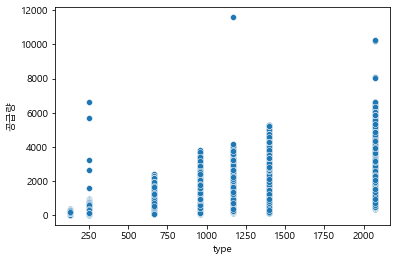

In [303]:
sns.scatterplot(x='type', y='공급량', data=df)

In [261]:
train = df.dropna()
test = df[df.isna()]

In [262]:
train

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,1395.356673,1209.032748,944.001457,1011.378763,983.333307,1120.250730,1118.775864,2515.207
2,2070.685900,1209.032748,956.397107,612.326706,983.333307,991.282511,1004.235536,1891.637
3,131.585481,805.711471,973.954300,942.007362,987.518102,870.413243,821.205454,109.378
4,958.564621,805.711471,936.336432,1117.409266,960.247853,702.687820,735.657258,977.093
5,664.626452,1136.587102,972.664864,683.393277,849.257779,919.078253,994.185752,500.036
...,...,...,...,...,...,...,...,...
383203,664.626452,637.341657,967.283845,1169.864435,983.333307,584.467229,513.607117,514.665
383204,1167.014483,1700.016547,965.702235,939.451053,987.518102,1773.318382,1812.769621,2662.203
383205,664.626452,1833.304906,939.885373,1029.675001,983.333307,1871.423806,1825.910156,1628.997
383206,248.866646,553.855529,956.397107,821.285596,983.333307,500.948025,516.657028,100.468


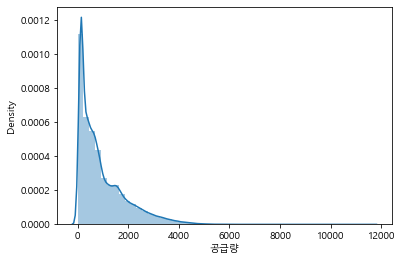

In [268]:
sns.distplot(train['공급량']);

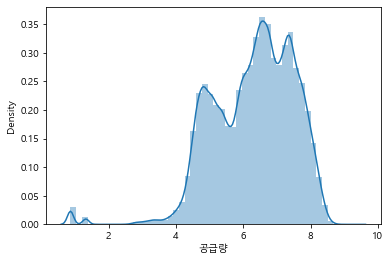

In [269]:
log_scale공급량 = np.log1p(df['공급량'])
sns.distplot(log_scale공급량);

In [270]:
train['공급량'] = log_scale공급량
train

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,1395.356673,1209.032748,944.001457,1011.378763,983.333307,1120.250730,1118.775864,7.830508
2,2070.685900,1209.032748,956.397107,612.326706,983.333307,991.282511,1004.235536,7.545726
3,131.585481,805.711471,973.954300,942.007362,987.518102,870.413243,821.205454,4.703911
4,958.564621,805.711471,936.336432,1117.409266,960.247853,702.687820,735.657258,6.885605
5,664.626452,1136.587102,972.664864,683.393277,849.257779,919.078253,994.185752,6.216678
...,...,...,...,...,...,...,...,...
383203,664.626452,637.341657,967.283845,1169.864435,983.333307,584.467229,513.607117,6.245457
383204,1167.014483,1700.016547,965.702235,939.451053,987.518102,1773.318382,1812.769621,7.887285
383205,664.626452,1833.304906,939.885373,1029.675001,983.333307,1871.423806,1825.910156,7.396333
383206,248.866646,553.855529,956.397107,821.285596,983.333307,500.948025,516.657028,4.619743


## 선형회귀분석

In [271]:
def NMAE(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    return score

In [272]:
X = train.drop(columns=['공급량'])
y = train['공급량']

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [275]:
LR = LinearRegression()
LR.fit(X_train, y_train)
pred = LR.predict(X_test)
NMAE(y_test, pred)

0.08165657785936929

In [276]:
RIDGE = Ridge()
RIDGE.fit(X_train, y_train)
pred = RIDGE.predict(X_test)
NMAE(y_test, pred)

0.08165657785948642

In [277]:
LASSO = Lasso()
LASSO.fit(X_train, y_train)
pred = LASSO.predict(X_test)
NMAE(y_test, pred)

0.08175892523284485

## 각각 모델의 변수별 coef 확인

In [278]:
def get_top_bottom_coef(model, n=5):
    coef = pd.Series(model.coef_, index=X.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [279]:
def get_nmae(model):
    pred = model.predict(X_test)
    nmae = NMAE(y_test, pred)
    print(model.__class__.__name__, 'NMAE:', np.round(nmae, 3))
    return nmae

def get_nmaes(models):
    nmaes = []
    for model in models:
        nmae = get_nmae(model)
        nmaes.append(nmae)
        
    return nmaes

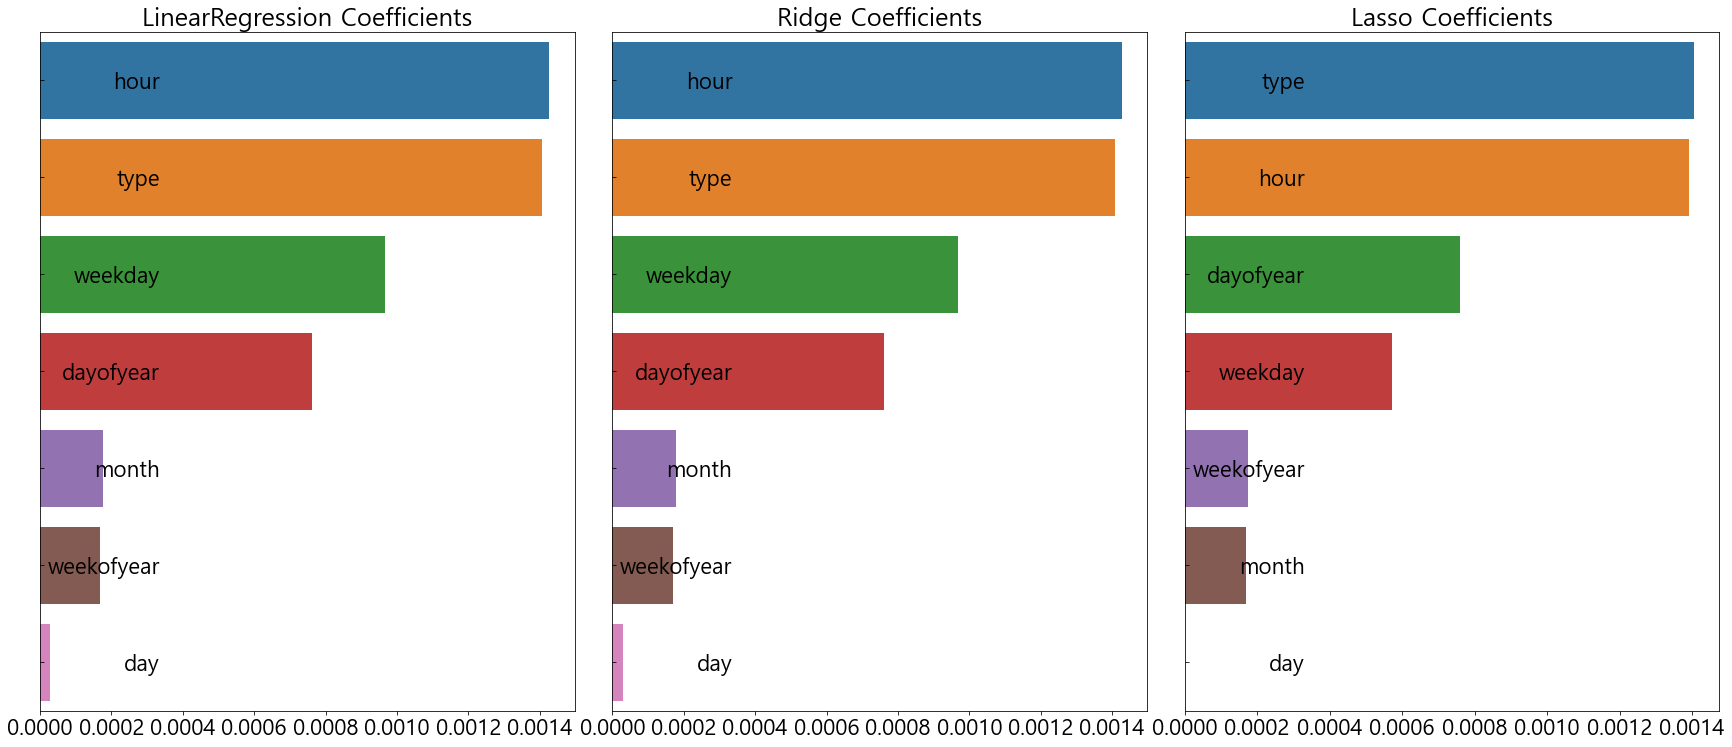

In [280]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [LR, RIDGE, LASSO]
visualize_coefficient(models)

In [281]:
def get_avg_nmae_cv(models):
    
    for model in models:
        nmae_list = -cross_val_score(model, X, y, scoring=make_scorer(NMAE, greater_is_better=False), cv=10)
        nmae_avg = np.mean(nmae_list)
        print('\n{0} CV NMAE 값 리스트: {1}'.format(model.__class__.__name__, np.round(nmae_list, 3)))
        print('{0} CV 평균 NMAE 값: {1}'.format(model.__class__.__name__, np.round(nmae_avg, 3)))

models = [LR, RIDGE, LASSO]
get_avg_nmae_cv(models)


LinearRegression CV NMAE 값 리스트: [0.083 0.081 0.08  0.08  0.081 0.083 0.082 0.08  0.083 0.083]
LinearRegression CV 평균 NMAE 값: 0.082

Ridge CV NMAE 값 리스트: [0.083 0.081 0.08  0.08  0.081 0.083 0.082 0.08  0.083 0.083]
Ridge CV 평균 NMAE 값: 0.082

Lasso CV NMAE 값 리스트: [0.083 0.081 0.08  0.08  0.081 0.083 0.083 0.081 0.083 0.083]
Lasso CV 평균 NMAE 값: 0.082


## 선형회귀 하이퍼파라미터 도출

In [282]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring=make_scorer(NMAE, greater_is_better=False), cv=5)
    grid_model.fit(X, y)
    nmae = -1*grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 NMAE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(nmae, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
lasso_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
print_best_params(RIDGE, ridge_params)
print_best_params(LASSO, lasso_params)

Ridge 5 CV 시 최적 평균 NMAE 값:0.0817, 최적 alpha:{'alpha': 0.0001}
Lasso 5 CV 시 최적 평균 NMAE 값:0.0817, 최적 alpha:{'alpha': 0.0001}


LinearRegression NMAE: 0.082
Ridge NMAE: 0.082
Lasso NMAE: 0.082


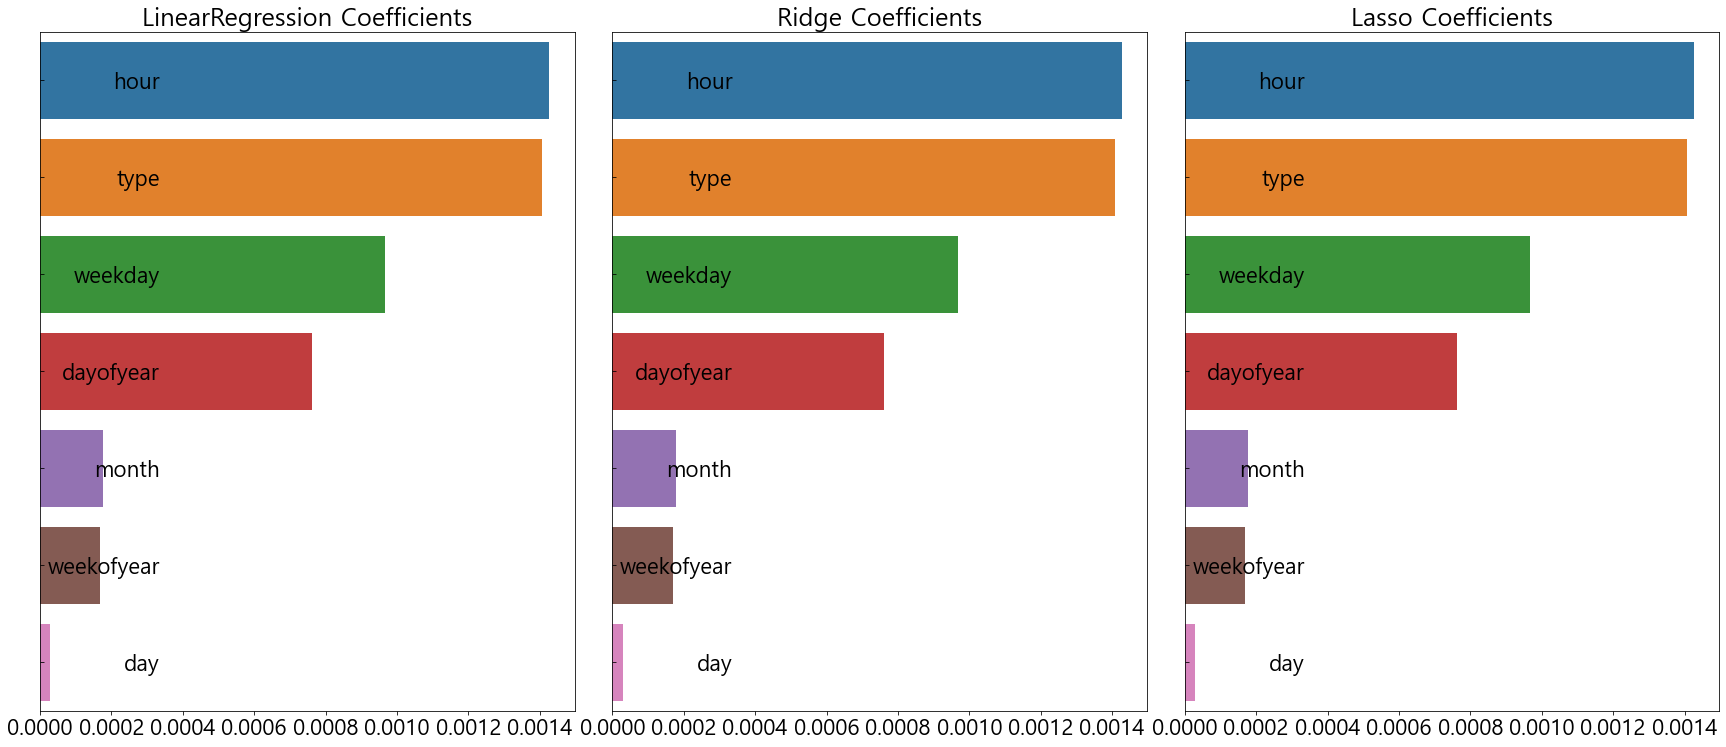

In [283]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=0.0001)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.0001)
LASSO.fit(X_train, y_train)

models = [LR, RIDGE, LASSO]
get_nmaes(models)

visualize_coefficient(models)

## 변수 왜곡도 처리

In [284]:
features_index = train.dtypes[train.dtypes != 'object'].index

skew_features = train[features_index].apply(lambda x : skew(x))

skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

Series([], dtype: float64)


In [285]:
train[skew_features_top.index] = np.log1p(train[skew_features_top.index])

In [286]:
X = train.drop(columns=['공급량'])
y = train['공급량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

ridge_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
lasso_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
print_best_params(RIDGE, ridge_params)
print_best_params(LASSO, lasso_params)

Ridge 5 CV 시 최적 평균 NMAE 값:0.0817, 최적 alpha:{'alpha': 0.0001}
Lasso 5 CV 시 최적 평균 NMAE 값:0.0817, 최적 alpha:{'alpha': 0.0001}


LinearRegression NMAE: 0.082
Ridge NMAE: 0.082
Lasso NMAE: 0.082


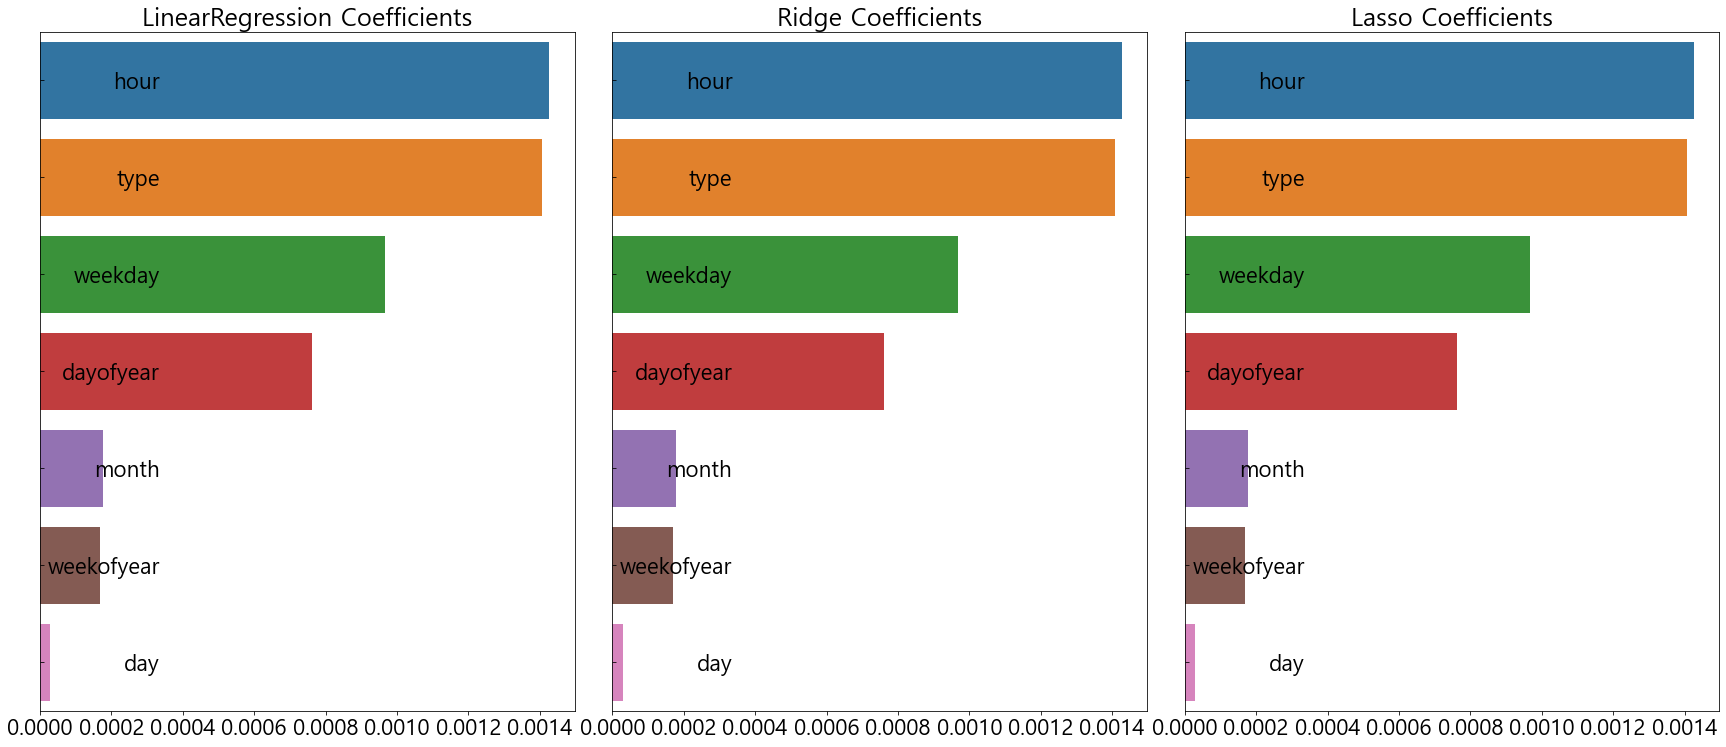

In [287]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=0.005)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.0001)
LASSO.fit(X_train, y_train)

models = [LR, RIDGE, LASSO]
get_nmaes(models)

visualize_coefficient(models)

## 이상치 제거

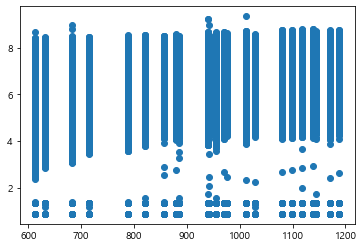

In [293]:
plt.scatter(x=train['hour'], y=train['공급량'])
plt.show()

In [296]:
cond1 = train['공급량'] < 3
cond2 = train['hour'] > 800
outlier_index = train[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 train shape:', train.shape)

train.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 train shape:', train.shape)

이상치 레코드 index : [ 10091  32124  81580 107175 111595 134611 138344 174883 236660 247281
 302317 321603 326974 333790 380751]
이상치 삭제 전 train shape: (365326, 8)
이상치 삭제 후 train shape: (365311, 8)


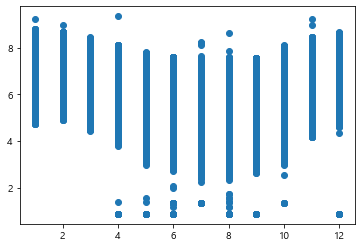

In [325]:
plt.scatter(x=train['month'], y=train['공급량'])
plt.show()

In [298]:
X = train.drop(columns=['공급량'])
y = train['공급량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

ridge_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
lasso_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
print_best_params(RIDGE, ridge_params)
print_best_params(LASSO, lasso_params)

Ridge 5 CV 시 최적 평균 NMAE 값:0.053, 최적 alpha:{'alpha': 0.0001}
Lasso 5 CV 시 최적 평균 NMAE 값:0.053, 최적 alpha:{'alpha': 0.0001}


LinearRegression NMAE: 0.053
Ridge NMAE: 0.053
Lasso NMAE: 0.053


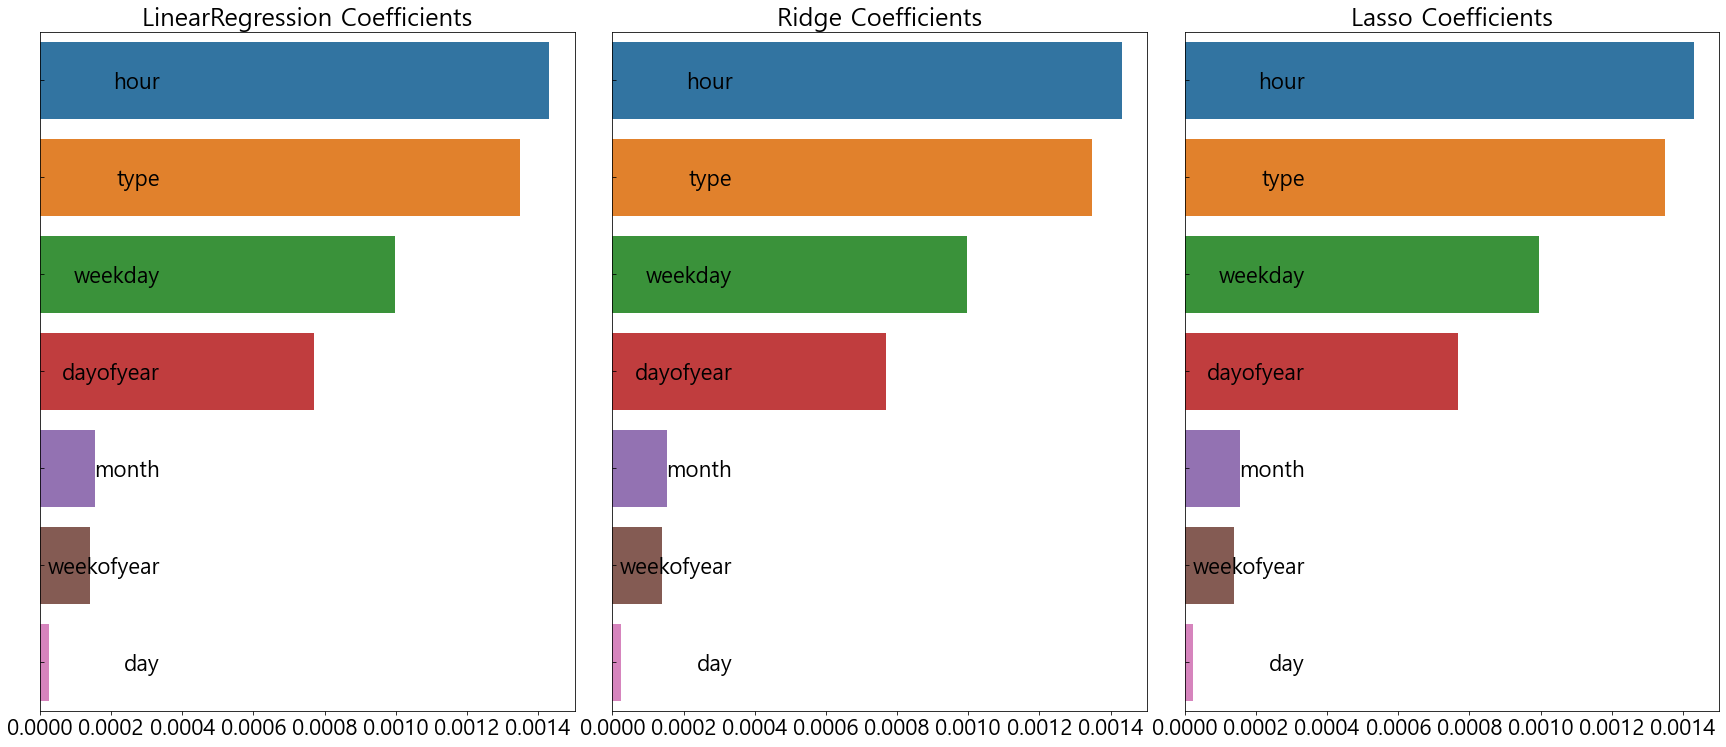

In [299]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=0.0001)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.0001)
LASSO.fit(X_train, y_train)

models = [LR, RIDGE, LASSO]
get_nmaes(models)

visualize_coefficient(models)

## 회귀트리분석

In [300]:
xgb_params = {'n_estimators':[500]}
XGBR = XGBRegressor()
print_best_params(XGBR, xgb_params)

XGBRegressor 5 CV 시 최적 평균 NMAE 값:0.0095, 최적 alpha:{'n_estimators': 500}


In [301]:
lgbm_params = {'n_estimators':[500]}
LGBMR = LGBMRegressor()
print_best_params(LGBMR, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 NMAE 값:0.0135, 최적 alpha:{'n_estimators': 500}


In [304]:
XGBR = XGBRegressor(n_estimators=500)
XGBR.fit(X_train, y_train)
LGBMR = LGBMRegressor(n_estimators=500)
LGBMR.fit(X_train, y_train)

models = [XGBR, LGBMR]
get_nmaes(models)

XGBRegressor NMAE: 0.01
LGBMRegressor NMAE: 0.013


[0.009571690963844182, 0.013437445624623299]

## 혼합모델 작성

In [305]:
def get_nmae_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        nmae = NMAE(y_test, pred_value)
        print('{0} 모델의 NMAE: {1}'.format(key, nmae))

In [306]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=0.0001)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.0001)
LASSO.fit(X_train, y_train)

lr_pred = LR.predict(X_test)
ridge_pred = RIDGE.predict(X_test)
lasso_pred = LASSO.predict(X_test)

pred = 0.4 * lr_pred + 0.4 * ridge_pred + 0.2 * lasso_pred
preds = {'최종 혼합': pred,
        'LinearRegression': lr_pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

get_nmae_pred(preds)

최종 혼합 모델의 NMAE: 0.053178813170552654
LinearRegression 모델의 NMAE: 0.053178812182889515
Ridge 모델의 NMAE: 0.05317881218288949
Lasso 모델의 NMAE: 0.053178817121208824


In [307]:
XGBR = XGBRegressor(n_estimators=500)
LGBMR = LGBMRegressor(n_estimators=500)
XGBR.fit(X_train, y_train)
LGBMR.fit(X_train, y_train)

xgb_pred = XGBR.predict(X_test)
lgbm_pred = LGBMR.predict(X_test)

pred = 0.4 * xgb_pred + 0.6 * lgbm_pred
preds = {'최종 혼합': pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}

get_nmae_pred(preds)

최종 혼합 모델의 NMAE: 0.011352171635119139
XGBM 모델의 NMAE: 0.009571690963844182
LGBM 모델의 NMAE: 0.013437445624623299


## 스태킹 앙상블

In [308]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [309]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

lr_train, lr_test = get_stacking_base_datasets(LR, X_train_n, y_train_n, X_test_n, 10)
ridge_train, ridge_test = get_stacking_base_datasets(RIDGE, X_train_n, y_train_n, X_test_n, 10)
lasso_train, lasso_test = get_stacking_base_datasets(LASSO, X_train_n, y_train_n, X_test_n, 10)
xgb_train, xgb_test = get_stacking_base_datasets(XGBR, X_train_n, y_train_n, X_test_n, 10)
lgbm_train, lgbm_test = get_stacking_base_datasets(LGBMR, X_train_n, y_train_n, X_test_n, 10)

LinearRegression model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작


In [310]:
Stack_final_X_train = np.concatenate((lr_train, ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((lr_test, ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

In [311]:
meta_model_lgbm = LGBMRegressor(n_estimators=500)
meta_model_xgbm = XGBRegressor(n_estimators=500)
meta_model_lr = LinearRegression()
meta_model_ridge = Ridge(alpha=0.0001)
meta_model_lasso = Lasso(alpha=0.0001)

In [312]:
meta_model_lgbm.fit(Stack_final_X_train, y_train)
final = meta_model_lgbm.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LGBM)의 최종 NMAE 값은:', nmae)

meta_model_xgbm.fit(Stack_final_X_train, y_train)
final = meta_model_xgbm.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(XGB)의 최종 NMAE 값은:', nmae)

meta_model_lr.fit(Stack_final_X_train, y_train)
final = meta_model_lr.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LR)의 최종 NMAE 값은:', nmae)

meta_model_ridge.fit(Stack_final_X_train, y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(RIDGE)의 최종 NMAE 값은:', nmae)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LASSO)의 최종 NMAE 값은:', nmae)

스태킹 회귀 모델(LGBM)의 최종 NMAE 값은: 0.00905730400349829
스태킹 회귀 모델(XGB)의 최종 NMAE 값은: 0.00902886721129286
스태킹 회귀 모델(LR)의 최종 NMAE 값은: 0.008925711207372405
스태킹 회귀 모델(RIDGE)의 최종 NMAE 값은: 0.008925833437064018
스태킹 회귀 모델(LASSO)의 최종 NMAE 값은: 0.008999007466054147


In [313]:
meta_model_lr.fit(Stack_final_X_train, y_train)
pred = meta_model_lr.predict(Stack_final_X_test)
NMAE(np.expm1(y_test), np.expm1(pred))

0.052552245002909934

## test 예측

In [314]:
df1

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,2497.129
1,0,1,1,2,1,1,1,2363.265
2,0,1,1,3,1,1,1,2258.505
3,0,1,1,4,1,1,1,2243.969
4,0,1,1,5,1,1,1,2344.105
...,...,...,...,...,...,...,...,...
15115,6,3,31,20,6,13,90,NaN
15116,6,3,31,21,6,13,90,NaN
15117,6,3,31,22,6,13,90,NaN
15118,6,3,31,23,6,13,90,NaN


In [315]:
df1['공급량'] = np.log1p(df1['공급량'])
df1[skew_features_top.index] = np.log1p(df1[skew_features_top.index])
df1

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,7.823297
1,0,1,1,2,1,1,1,7.768222
2,0,1,1,3,1,1,1,7.722901
3,0,1,1,4,1,1,1,7.716447
4,0,1,1,5,1,1,1,7.760085
...,...,...,...,...,...,...,...,...
15115,6,3,31,20,6,13,90,NaN
15116,6,3,31,21,6,13,90,NaN
15117,6,3,31,22,6,13,90,NaN
15118,6,3,31,23,6,13,90,NaN


In [316]:
train = df1.dropna()
test = df1[df1['공급량'].isna()]

In [317]:
X_train_n = train.drop(columns=['공급량']).values
X_test_n = test.drop(columns=['공급량']).values
y_train_n = train['공급량'].values

lr_train, lr_test = get_stacking_base_datasets(LR, X_train_n, y_train_n, X_test_n, 10)
ridge_train, ridge_test = get_stacking_base_datasets(RIDGE, X_train_n, y_train_n, X_test_n, 10)
lasso_train, lasso_test = get_stacking_base_datasets(LASSO, X_train_n, y_train_n, X_test_n, 10)
xgb_train, xgb_test = get_stacking_base_datasets(XGBR, X_train_n, y_train_n, X_test_n, 10)
lgbm_train, lgbm_test = get_stacking_base_datasets(LGBMR, X_train_n, y_train_n, X_test_n, 10)

LinearRegression model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작


In [318]:
Stack_final_X_train = np.concatenate((lr_train, ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((lr_test, ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

In [319]:
pred = XGBR.predict(test.drop(columns=['공급량']))
pred

array([7.820146 , 7.799397 , 7.6669407, ..., 5.968593 , 5.88729  ,
       5.805482 ], dtype=float32)

In [320]:
test['공급량'] = np.expm1(pred)
test

,type,month,day,hour,weekday,weekofyear,dayofyear,공급량
0,0,1,1,1,1,1,1,2489.269287
1,0,1,1,2,1,1,1,2438.130615
2,0,1,1,3,1,1,1,2135.535156
3,0,1,1,4,1,1,1,2164.387451
4,0,1,1,5,1,1,1,2242.209473
...,...,...,...,...,...,...,...,...
15115,6,3,31,20,6,13,90,441.948242
15116,6,3,31,21,6,13,90,433.750946
15117,6,3,31,22,6,13,90,389.955261
15118,6,3,31,23,6,13,90,359.427216


In [321]:
submission = pd.read_csv('data/sample_submission.csv')

In [322]:
submission['공급량'] = np.expm1(pred)

In [323]:
submission.to_csv('mean_staking_xgbm.csv', index=False)

In [324]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,2489.269287
1,2019-01-01 02 A,2438.130615
2,2019-01-01 03 A,2135.535156
3,2019-01-01 04 A,2164.387451
4,2019-01-01 05 A,2242.209473
...,...,...
15115,2019-03-31 20 H,441.948242
15116,2019-03-31 21 H,433.750946
15117,2019-03-31 22 H,389.955261
15118,2019-03-31 23 H,359.427216
